## Computing CAS scores

Let $M$ be the membership matrix of dimension $n \times k$ where $n$ is the number of nodes and $k$ the number of communities such that $M_{i,j}=1$ iff node $i$ is in community $j$, else 0.

Recall that each vertex can have multiple (or no) membership. A partition yields a single membership per node (row sums are all 1).

#### IEF and Beta

$IEF_A(v) = \frac{deg_A(v)}{deg(v)}$

$Beta_A(v) =  IEF_A(v) - p(A)$

where:

* $p(A) = vol(A)/vol(V)$
* $deg_A(v)$: number of neighbours $w$ of node $v$ with $w \in A$
* $deg(v)$: is the usual degree
* $vol(A)$: sum of degree of all nodes $w \in A$
* $vol(V)$: sum of degree of all nodes, i.e. twice the number of edges in the graph

Computing all $IEF_A(v)$ is a special case of the following with $\alpha=1$:

$D^{-1} \left((1-\alpha)A^2 + \alpha A \right) M$

where $D$ is the diagonal matrix of degrees, $A$ is the adjacency and $M$ if the community membership matrix.


#### C

$C_A(v) = \frac{Beta_A(v) * \sqrt{deg(v)}}{\sqrt{p(A)(1-p(A))}}$

This measures the number of standard deviations away from the expected number of edges from node $v$ to community $A$, assuming a binomial distribution.

#### P-values

This scores amounts to one minus the p-value for the number of edge into some community assuming a binomial distribution, that is:

$P_A(v) = Pr(bin(n=deg(v), p=p(A)) \le deg_A(v)$

#### Membership matrix M

In practice, we drop negative values to keep all matrices above sparse.

Given a score matrix S (one of the above), we can replace the membership matrix with a new matrix $M$ such that $M_{i,j} = 1$ iff $S_j(i) \ge s^*$ else 0.

Given this updated matrix $M$, we can re-compute the score matrix. 
This process can be repeated several times.


In [1]:
import pickle
import igraph as ig
from collections import Counter
from matplotlib import pyplot as plt
from CAS import *

In [2]:
with open('abcdo.pkl','rb') as fp:
    g = pickle.load(fp)

In [3]:
### Get initial partition and adjacency
L = g.community_leiden(objective_function='modularity').membership
M = partition2sparse(L)
A = g.get_adjacency_sparse()

### Compute Beta and C scores; also get degrees w.r.t. initial partition
IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


In [4]:
## Outliers - those have 'gt' equal to 0
Counter(np.array(g.vs['gt'])==0)

Counter({False: 950, True: 50})

In [5]:
### re-compute membership matrix given score and threshold
M = score_to_memberships(IEF, DegPart, threshold=.55, min_deg_in=2)
### number of memberships
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
### compare to GT outliers
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([g.vs[i]['gt']==0 for i in outliers]))


Counter({1: 950, 0: 50})
outliers found: 50
ground-truth outliers found: 50


In [6]:
### re-compute membership matrix given score and threshold
M = score_to_memberships(Beta, DegPart, threshold=.4, min_deg_in=2)
### number of memberships
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
### compare to GT outliers
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([g.vs[i]['gt']==0 for i in outliers]))


Counter({1: 950, 0: 50})
outliers found: 50
ground-truth outliers found: 50


In [7]:
### re-compute membership matrix given score and threshold
M = score_to_memberships(C, DegPart, threshold=3.5, min_deg_in=2)
### number of memberships
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
### compare to GT outliers
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([g.vs[i]['gt']==0 for i in outliers]))


Counter({1: 932, 0: 64, 2: 4})
outliers found: 64
ground-truth outliers found: 43


In [8]:
### re-compute membership matrix given score and threshold
M = score_to_memberships(Pv, DegPart, threshold=.985, min_deg_in=2)
### number of memberships
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
### compare to GT outliers
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([g.vs[i]['gt']==0 for i in outliers]))


Counter({1: 952, 0: 45, 2: 3})
outliers found: 45
ground-truth outliers found: 45


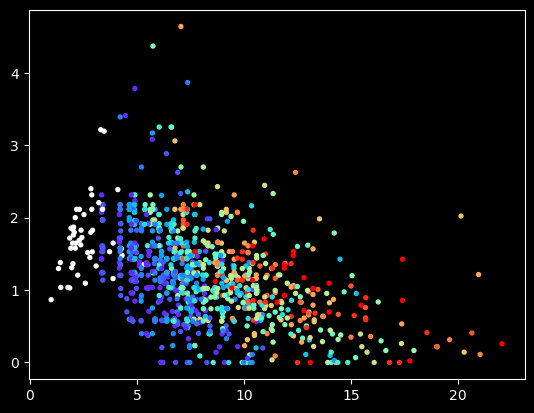

In [9]:
## looking at top-2 C scores
CC = np.array(C.todense())
X = np.array([list(x.argsort()[-2:]) for x in CC])
Y = np.array([ [CC[i][X[i][1]],CC[i][X[i][0]]] for i in range(g.vcount())])
plt.style.use('dark_background')
plt.scatter(Y[:,0],Y[:,1], c=g.vs['color'], s=8);


In [10]:
### loop - update C matrix
M = score_to_memberships(C, DegPart, threshold=3, min_deg_in=2)
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
_I, _Beta, C, _S, _Deg = CAS(A, M, alpha=1)
M = score_to_memberships(C, DegPart, threshold=3, min_deg_in=2)
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
_I, _Beta, C, _S, _Deg = CAS(A, M, alpha=1)
M = score_to_memberships(C, DegPart, threshold=3, min_deg_in=2)
print(Counter(M.sum(axis=1).flatten().tolist()[0]))
### compare to GT outliers
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([g.vs[i]['gt']==0 for i in outliers]))


Counter({1: 950, 0: 36, 2: 14})
Counter({1: 952, 0: 38, 2: 10})
Counter({1: 948, 0: 40, 2: 12})
outliers found: 40
ground-truth outliers found: 40
